@ARTICLE{Thorndike53,
    author = {Robert L. Thorndike},
    title = {Who belongs in the family},
    journal = {Psychometrika},
    year = {1953},
    pages = {267--276}
}

In [1]:
import os
import random
import numpy as np
import h5py
import matplotlib.pyplot as plt

from numba import cuda, jit

from dask import delayed, compute
from dask.diagnostics import ProgressBar

from sklearn.preprocessing import  StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA as IPCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

import rasterio as rio

import xarray as xr
import rioxarray

import glob

In [2]:
# path and sitename
site = 'TEAK'
path = f'/media/data/NEON/{site}'
other_path = f'{path}/hyperspectral/DP3.30006.001/'
years = [y for y in os.listdir(other_path) if os.path.isdir(os.path.join(other_path, y))]

# make a dict with paths to all files for each year
data_dict = {}
for year in years:
    globstring = f'{path}/hyperspectral/DP3.30006.001/{year}/FullSite/D??/{year}_{site}_*/L3/Spectrometer/Reflectance/*.h5'
    data_dict[year] =  glob.glob(globstring)

# ensure directory for tiffs exists and make path
pca_house = os.path.join(path, 'pca')
os.makedirs(pca_house, exist_ok=True)


In [3]:
def band_list():
    '''excludes bands with H2O or CO2 absorption'''
    good_bands = np.hstack([
        np.arange(0, 188 + 1),
        np.arange(211, 269 + 1),
        np.arange(316, 425 + 1)
    ])
    
    return good_bands


PCA and kmeans clustering were performed using **-----python modules and versions-----**. In order to determine the optimal number of  PCA components, $n_{comp}$ and  k-means clusters, $n_{km}$ for each site, pixels were randomly sampled from each of the reflectance files (hdf5 format) for each site and  available year. Each sample collection  was then scaled  and fit to a pca model using Sklearn (**version , citation**).  Cumulative explained variance vs number of PCA components for each sample collection was plotted and used to select the best values of $n_{comp}$. At least 85% of explained variance (in many cases considerably more) was captured by the chosen $n_{comp}$, typically resulting in **2 - 3 components with some using more blah blah**.

Next, an Incremental PCA (IPCA) model using $n_{comp}$ was fit for each site using the samples from all available years. The fit IPCA model was then used to perform k-means clustering for each year using a a range of 2 - 10 clusters. for each run using a different number of clusters the within-cluster sum of squares (WCSS) was calculated.  For each year WCSS vs. number of clusters was plotted. The plots for all available years were visually inspected and the best value of $n_{km}$ was chosen based on the the "elbow rule" \cite{Thorndike53}.  The same values for $n_{comp}$ and $n_{km}$ were used across all years for a given site in order to facilitate comparisons across years.   

 Each hyperspectral tile for a given site was then transformed using the previously fit IPCA model. All of the transformed tiles for a given year were then aggregated into one mosaic which covers the entire footprint extent. The mosaic was then classified using k-means clustering with $n_{km}$ clusters.

In [4]:
@delayed
def sample_from_file(fname, size):
    '''samples from file'''
    
    # open the file
    f = h5py.File(fname, 'r')

    # get the within reflectance as np array
    refl_array = np.array(np.rot90(f[site]['Reflectance']['Reflectance_Data']))

    # drop bad bands from refl_array
    refl_array = refl_array[:, :, band_list()]

    # get shape of wavelenght dimension
    wl = refl_array.shape[2]

    # reshape
    flat_refl = refl_array.reshape(-1, wl)

    # drop nulls
    flat_refl = flat_refl[
    (~np.any(flat_refl == -9999, axis=1)) &
    (~np.any(np.isnan(flat_refl), axis=1))]

    # get random sample indices
    sample_idx = random.sample(range(flat_refl.shape[0]), int(flat_refl.shape[0] * size))

    # return sample
    return flat_refl[sample_idx, :]
    

def sample_from_all(files, size):
    '''
    Returns a np array of samples of shape (N, wl) where N is
    the number of samples and wl is the length of the wavelength
    dimension.
    
    args:
        files    - list of full paths to netcdf4 files to be used. 
        size     - fraction of data to be used.
    '''
    # empty list for samples
    samples = []
    
    for fname in files:
        samples.append(sample_from_file(fname, size))
        
    with ProgressBar():
        sample = np.vstack(compute(*samples))
        
    return sample


def plot_pca_var(pca):
    '''plots explained variance by PCA component'''
    
    # make fig
    plt.figure(figsize=(10,4));

    # plot
    plt.plot(range(1, 359),
             pca.explained_variance_ratio_.cumsum(),
             marker='o',
             linestyle='--');
    
    # details
    plt.title('Explained Variance by Number of Components');
    plt.xlabel('Components');
    plt.ylabel('Cumulative explained Var');
    plt.xlim(0, 20);
    plt.show()
    
    
def kmeans_wcss(n_components, scaled_refl_list, max_n_clusters=20):
    '''
    Returns a list of wcss values for different n_clusters values
    after performing PCA using n_components.
    args:
        n_components   - number of components to be kept in PCA.
        scaled_refl    - scaled values on which to perform PCA and
                         clustering.
        max_n_clusters - max number of clusters to try default 20.
    '''
    # use n components for pca
    pca = IPCA(n_components=n_components)

    # empty lists
    scores_pca = []
    wcss = []

    for scaled_refl in scaled_refl_list:
        # fit
        pca.partial_fit(scaled_refl)

    for scaled_refl in scaled_refl_list:
        # get component scores
        scores_pca.append(pca.transform(scaled_refl))

    # now try out some different cluster numbers
    for i, score in enumerate(scores_pca):
        print(f'Out of {i} dtasets and {max_n_clusters} trials working on:')

        w = []

        for n in range(1, max_n_clusters + 1):
            
            print(f'\b\b\b\b\b\b{i} : {n}', end="")
            
            kmeans =  KMeans(n_clusters=n, init='k-means++', random_state=42)
            kmeans.fit(score)
            w.append(kmeans.inertia_)

        wcss.append(w)

        print('\ndone!')
    
    return wcss, pca


def plot_wcss(wcss):
    '''plots wcss vs n_clusters'''
    
    # fig
    fig = plt.figure(figsize=(10, 4))

    # plot
    plt.plot(range(1, len(wcss) + 1),
             wcss,
             marker='o',
             linestyle='--');

    # details
    plt.title('Kmeans with PCA WCSS');
    plt.xlabel('WCSS');
    plt.ylabel('Number of Clusters');

    plt.show()

    return(fig)

Starting 2019
[########################################] | 100% Completed | 11min 38.6s


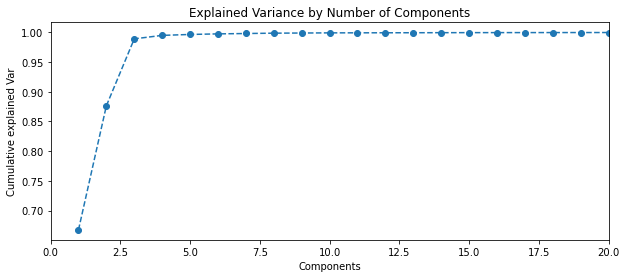

Starting 2021
[########################################] | 100% Completed | 12min 18.4s


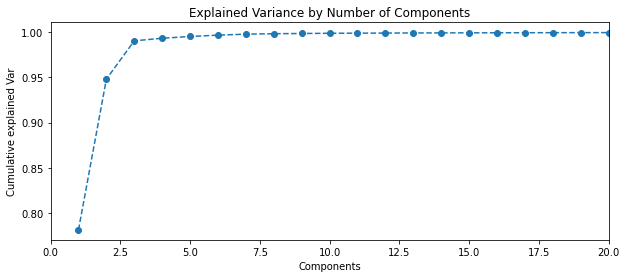

In [5]:
# TODO: on cyverse the sample size can be bigger, also try to do a random seed for reproduceabilty
size = 1 / 500

figs = []
scaled_datasets = []

for y in data_dict.keys():
    print(f'Starting {y}')

    # new name for the contents of the dict at key
    files = data_dict[y]

    # get sample
    sample = sample_from_all(files, size)
    sample = np.array(sample, dtype=np.float16)

    # scale the data
    scaler = StandardScaler().fit(sample)
    scaled = scaler.transform(sample)

    # save scaled for later
    scaled_datasets.append(scaled)

    # instantiate the PCA thingy
    pca = PCA()

    # fit the pca model
    pca.fit(scaled)

    # try to free up sume memory
    del sample

    figs.append(plot_pca_var(pca))

From the plots above it can bee seen the for each year 2 components capture more than ~85% of observed variance in the data, 3 components captures nearly all of it **------Should probably make the graphs annotate the first few points so we can see the exact number-----**. We could get away with using with using 2 components, but will use 3  as it is still a quite reasonably small number and three provides a large increase in observed variance over 2.

In [6]:
# 2 components as discussed above
n_components = 3

# get wcss for different n_clusters and train the pca for n_components
wcss_figs = []

wcss, pca = kmeans_wcss(n_components, scaled_datasets, max_n_clusters=10)

for i, y in enumerate(data_dict.keys()):
    print(y)
    print(wcss[i])
    wcss_figs.append(plot_wcss(wcss[i]))

Out of 0 dtasets and 10 trials working on:
0 :0 :0 :0 :0 :0 :0 :0 :0 :0 : 10
done!
Out of 1 dtasets and 10 trials working on:
1 :1 :1 :1 :1 :1 :1 :1 :1 :1 : 10

There is a strong inflection after three clusters. So we will use three clusters as per the "elbow rule" \cite{Thorndike53}.

In [ ]:
# 3 clusters as discussed above
n_clusters = 3

Next we perform PCA on each tile using the $n_{comp}$ and $n_{clusters}$ determined from the sample.

In [ ]:
def read_h5_do_pca(fname, scaler, pca):
    '''reads'''  

    # open the file
    f = h5py.File(fname, 'r')
    
    # seperate out reflectance
    refl = f[site]['Reflectance']

    # get no data value
    no_data_value = refl['Reflectance_Data'].attrs['Data_Ignore_Value']
    
    # get the actual data within reflectance as array
    refl_array = np.array(np.rot90(refl['Reflectance_Data'], k=3), dtype=np.float16)
    
    # drop bad bands from refl_array
    refl_array = refl_array[:, :, band_list()]
    
    # get wavelength info
    wavelengths = np.array(refl['Metadata']['Spectral_Data']['Wavelength'])
    
    # drop bad bands from wavelength
    wavelengths = wavelengths[band_list()]
    
    # get  dimensions of array
    x  = refl_array.shape[0]
    y  = refl_array.shape[1]
    wl = refl_array.shape[2]

    # reshape
    flat_refl = refl_array.reshape(-1, wl)
    
    # make sure there are no nans
    flat_refl[np.isnan(flat_refl)] = no_data_value
    
    # before we drop no-datas get their indices
    null_idx = np.argwhere(np.any(flat_refl == no_data_value, axis=1)).flatten()

    # pick arbitray valid index
    good_idx = np.argwhere(~np.any(flat_refl == no_data_value, axis=1)).flatten()[25]
    
    # fill no-datas with a vaule within normal range if need be (they will be returned to na data val in output)
    if null_idx.any():
        #flat_refl = flat_refl[np.argwhere(~np.any(flat_refl == no_data_value, axis=1)).flatten()]
        flat_refl[null_idx] = flat_refl[good_idx]

    # scale with previously fit scaler
    scaled = scaler.transform(flat_refl)
    
    # get component scores
    scores_pca = pca.transform(scaled)
    
    # put no-data values back in if need be
    if null_idx.any():
        #scores_pca = np.insert(scores_pca, null_idx, [no_data_value] * scores_pca.shape[1], axis=0)
        scores_pca[null_idx, :] = [no_data_value] * scores_pca.shape[1]

    # reshape to original tile x, y
    scores_pca = scores_pca.reshape(x, y, n_components)
    
    # close hdf
    #f.close()
    
    return scores_pca, refl

    
def tiffize_and_xarray(arr, refl, out_file):
    '''
    Writes tiff from array.
    
    args:
        arr      - array to be written as tiff
        refl     - reflectance metadata from h5
        out_file - filename of tiff to write
    '''
    # bag crs as epsg
    epsg = refl['Metadata']['Coordinate_System']['EPSG Code'][()].decode("utf-8")
    epsg = f'EPSG:{epsg}'
    
    # bag other crs info
    crs_info = refl['Metadata']['Coordinate_System']['Map_Info'][()].decode("utf-8").split(',')


    # get corners and x, y resolution
    xmin = float(crs_info[3])
    ymax = float(crs_info[4])
    xres = float(crs_info[5])
    yres = float(crs_info[6])
    xmax = xmin + (arr.shape[1] * xres) 
    ymin = ymax - (arr.shape[0] * yres)

    # create array of x center pixel locations in utm coords
    x = np.linspace(xmin, xmax, arr.shape[1], endpoint=False)
    x = x + xres * 0.5

    # create array of y center pixel locations in utm coords
    y = np.linspace(ymin, ymax, arr.shape[0], endpoint=False)
    y = y + yres * 0.5

    # make dataset
    d_all = xr.DataArray(arr, dims=['x', 'y', 'components'], coords={'x':x, 'y':y, 'components': range(arr.shape[2])})
    d_all.name = 'pca'
    d_all = d_all.to_dataset()
    
    # assign crs and spatial dims
    d_all.rio.write_crs(epsg, inplace=True)

    # attributes
    no_data_value = refl['Reflectance_Data'].attrs['Data_Ignore_Value']
    d_all.attrs = {
                    'no_data_value': no_data_value,
                    'epsg': epsg,
                    'crs' : crs_info
                  }

    # write the labels to geotiff
    d_all.pca.transpose('components', 'y', 'x').rio.to_raster(out_file)
    
    return d_all
    
    
    

In [ ]:
for year in data_dict.keys():
    print(f'Starting {year}')

    # new name for the contents of the dict at key
    files = data_dict[year]

    print(f'Of {len(files)} on:')

    # list for xarrays to merge later
    xarrays = []

    for i, f in enumerate(files):
        
        print(f'\b\b\b{i + 1}')

        base = os.path.basename(f).split('.')[0].split('_')
        base = '_'.join([base[2], base[4], base[5]])

        scores_pca, refl = read_h5_do_pca(f, scaler, pca)                            

        # make fname
        tiff = os.path.join(pca_house, f'{base}_{year}_pca.tiff')

        xarrays.append(tiffize_and_xarray(scores_pca, refl, tiff))


    # make mosaic
    print('Creating mosaic...')

    mosaic = xr.combine_by_coords(xarrays, combine_attrs='override')
    no_data_value = mosaic.attrs['no_data_value']

    print('Performing kmeans...')

    # get the nice unified pca array
    pca_arr = mosaic.pca.data

    # determine number of pca compnents in use
    comps = mosaic.components.data.shape[0]

    # flatten the pca img
    flat_pca = pca_arr.reshape(-1, comps)

    # before we drop no-datas get their indices
    null_idx = np.argwhere(np.any(flat_pca == no_data_value, axis=1)).flatten()

    # pick arbitray valid index
    good_idx = np.argwhere(~np.any(flat_pca == no_data_value, axis=1)).flatten()[25]

    # drop no-datas
    if null_idx.any():
        flat_pca[null_idx] = flat_pca[good_idx]

    # cluster
    kmeans =  KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(flat_pca)

    # get labels
    labels = kmeans.labels_

    # add the labels to the xarray
    mosaic['kmeans_label'] = xr.DataArray(labels.reshape(pca_arr.shape[0], pca_arr.shape[1]), dims=['x', 'y'])

    print('Writing mosaic tiffs and netcdf...')

    # ensure directory for mosaics exists and make path
    mosaic_house = os.path.join(path, 'mosaic')
    os.makedirs(mosaic_house, exist_ok=True)

    # make fname
    tiff = os.path.join(mosaic_house, f'{site}_{year}_kmeans_mosaic.tiff')

    # write the labels to geotiff
    mosaic.kmeans_label.transpose('y', 'x').rio.to_raster(tiff, dtype=np.int8)

    # make fname
    tiff = os.path.join(mosaic_house, f'{site}_{year}_pca_mosaic.tiff')

    # write the labels to geotiff
    mosaic.pca.transpose('components', 'y', 'x').rio.to_raster(tiff)

    # save netcdf
    ncdf = os.path.join(mosaic_house, f'{site}_{year}_mosaic.nc')
    mosaic.to_netcdf(ncdf)

    print(f'Done with {year}')

Starting 2019
Of 129 on:
1
2


KeyboardInterrupt: 


    # calculate the spectral indices and add to dataset
    ndvi = ((d_all.reflectance.sel(wl=858.6,
                                   method='nearest') -
             d_all.reflectance.sel(wl=648.2,
                                   method='nearest')) /
            (d_all.reflectance.sel(wl=858.6,
                                   method='nearest') +
             d_all.reflectance.sel(wl=648.2,
                                   method='nearest'))
           ).assign_coords(index='ndvi').expand_dims('index')


    cai = ((0.5 *
            (d_all.reflectance.sel(wl=2000,
                                   method='nearest') /
             10000.0 +
             d_all.reflectance.sel(wl=2200,
                                   method='nearest') /
             10000.0)) - d_all.reflectance.sel(wl=2100.0,
                                              method='nearest') /
          10000.0).drop('wl').assign_coords(index='cai').expand_dims('index')


    ndli = ((np.log(1. /
                           (d_all.reflectance.sel(wl=1754.,
                                                  method='nearest') /
                            10000.0)) -
             np.log(1.0 /
                           (d_all.reflectance.sel(wl=1680.0,
                                                  method='nearest') /
                          10000.0))) /
            (np.log(d_all.reflectance.sel(wl=1754.0,
                                                 method='nearest') /
                           10000.0) +
             np.log(d_all.reflectance.sel(wl=1680,
                                               method='nearest') /
                           10000.0))).assign_coords(index='ndli').expand_dims('index')


    mrendvi = ((d_all.reflectance.sel(wl=750.0,
                                      method='nearest') -
                d_all.reflectance.sel(wl=705.0,
                                      method='nearest')) /
               (d_all.reflectance.sel(wl=750.0,
                                      method='nearest') +
                d_all.reflectance.sel(wl=705.0,
                                      method='nearest') -
                (2.0 *
                 d_all.reflectance.sel(wl=445.0,
                                       method='nearest')
                )
               )
              ).drop('wl').assign_coords(index='mrendvi').expand_dims('index')


    sipi = ((d_all.reflectance.sel(wl=800.0,
                                   method='nearest') -
             d_all.reflectance.sel(wl=445.0,
                                   method='nearest')) /
            (d_all.reflectance.sel(wl=800.0,
                                   method='nearest') -
             d_all.reflectance.sel(wl=680.0,
                                   method='nearest')
            )
           ).assign_coords(index='sipi').expand_dims('index')


    ndni = ((np.log(10000.0 /
                           d_all.reflectance.sel(wl=1510.0,
                                                 method='nearest')
                          ) -
             np.log(10000.0 /
                           d_all.reflectance.sel(wl=1680.0,
                                                 method='nearest')
                          )
            ) / 
            (np.log(10000.0 /
                           d_all.reflectance.sel(wl=1510.0,
                                                 method='nearest')
                          )+np.log(10000.0 /
                           d_all.reflectance.sel(wl=1680.0,
                                                 method='nearest')
                                         )
            )
           ).assign_coords(index='ndni').expand_dims('index')


    cri1 = ((1.0 /
             (d_all.reflectance.sel(wl=510.0,
                                    method='nearest') /
              10000.0)
            ) -
            (1.0 /
             (d_all.reflectance.sel(wl=550.0,
                                    method='nearest') /
              10000.0)
            )
           ).assign_coords(index='cri1').expand_dims('index')


    cri2 = ((1.0 /
             (d_all.reflectance.sel(wl=510.0,
                                    method='nearest') / 10000.0)
            ) - 
            (1.0 /
             (d_all.reflectance.sel(wl=700.0,
                                    method='nearest') /
              10000.0)
            )
           ).assign_coords(index='cri2').expand_dims('index')


    d_all['indices'] = xr.concat(
        [ndvi,
         cai, 
         ndli, 
         mrendvi, 
         sipi, 
         cri1, 
         cri2],
        dim='index').chunk((1.0,
                            d_all.reflectance.data.chunksize[0],
                            d_all.reflectance.data.chunksize[1])
                          ).transpose('y','x','index').chunk(('auto','auto',1))

    return d_all